# Task 1 (complete by Sunday Week 5, 03/03/24)

## 1.1 Overview
Implement tabular Q-Learning for the problem outlined in Example 6.5 (Windy Grid World) OR Example 6.6 (Cliff Walking Grid World) in the Reinforcement Learning Sutton and Barto’s text on Reinforcement Learning, 2nd Edition (2018) (http://incompleteideas.net/book/the-book-2nd.html).

POST and RESPOND by the suggested completion date.

### 1.1.1 Post Task 1 (complete by Sunday of Week 5, 3/03/24)
Please upload your code for Task 1 to the group locker by Saturday Week 6 if possible. The implementation does not need to be complete and you can continue to upload improved versions.

### 1.1.2 Respond to Task 1 (complete by Monday Week 6,  04/03/24)
Use the Etivity 3 forum to provide constructive feedback to your peers in Task 1 focused on tabular Q Learning. Consider:

* Are the results correct?  Do they approximate the published results in the recommended text?
* Are the Q values depicted? Is the policy graphed? If not, suggest how to illustrate these elements of the solution.
* Suggest improvments with respect to parameters such as epsilon and gamma.

## 1.2 Objective

The purpose of this e-tivity is to clarify your understanding of both on-policy and off-policy Temporal Difference (TD) methods in tabular format using Grid World use cases.

## 1.3 Solution Template Sample

Original file is located at
    https://colab.research.google.com/drive/1yZ5BRMKqgENcBRV31vgd8NPy9Amvgknz

A partial solution for Task 1 Etivity 3
Substantial blocks of code deleted.
Temporal Difference method
Some deliberate errors injected.

* Correct bugs
* Insert commentary
* Add code to visualise Q table and Policy.
* Compare Sarsa and Q Temporal Difference (TD) learning methods.

## 1.4 Adapted Template Solution
 The following is an adaption of the supplied sample template with bug fixes and other amendments. The code has been extensively commented for learning purposes with narrative added about behaviour verified from related reading sources.

In [79]:
import numpy as np
import matplotlib.pyplot as plt

action_names = ["up", "down", "right", "left"]

S_start = (3, 0)   # start location
S_goal = (3, 7)    # target location
wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
reward = -1

# RF hyperparameters
#alpha = 0.5     # 0.9    # optimized
#alpha = 0.5     # from Sutton & Barto example
alpha = 0.1      # template
                 # Learning Rate (or more accurately "step-size parameter" as described in Sutton & Barlo Fig 1.1 p.10 which "incfluences the rate of learning")
                 #  Rate at which algorithm updates estimated values of action at each state.
                 #  larger alpha means faster learning however might result in unstable estimates.

#epsilon = 0.5   # 0.5   # optimized
#epsilon = 0.1   # from Sutton & Barto example
epsilon = 0.2    # template
                 # Exploration Rate (or "tendency to explore" as described by Sutton & Baro Ch.1)
                 #  In epsilon-greedy strategy, dictates how often the algorithm will choose random action
                 #  over the one it believes is best. This ensures algorithm doesn't get stuck exploiting early (suboptimal) findings.
                 #  An epsilon of 0.2 means a 20% chance the algorithm chooses a random action at each step.

#gamma   = 0.6   #  0.7   # optimized
#gamma   = 1.0   #  from Sutton & Barto example (undiscounted)
gamma   = 0.9    #  template
                 # Discount Factor
                 #  Discounts the value of future rewards as they are projected back to the present.
                 #  Balances the trade-off between immediate and future rewards, influencing both the strategy and efficiency of the learning process.
                 #  Reward received k time steps in the future is worth gamma^k times what it would be worth if received immediately
                 #  This means that as gamma approaches 0, prioritises immediate rewards over distant ones (short-term gains)
                 #  Conversely, as gamma approaches 1, values future rewards almost as highly as immediate rewards (long-term perspective).
                 #  0.9 means algorithm gives significant importance to future rewards

# Initialization values for the Q matrix
# A (row, col) couple represents the location of a single cell of the grid.
# The value of Q matrix at location (row, col) represents the current action for that location
num_rows = 7     # Assume 7 rows in Windy grid.
num_cols = 10    # Assume 10 columns in Windy grid
num_actions = 4  # Assume 4 different actions are possible from each state


def init_Q(Q, init_type=1):
    """
    Init Q-values

    Q: numpy array to initialize

    init_type:  1 - by default, random [0, 1]
                2 - zeros
    """
    if init_type == 2:
        # Set all values in Q-table to zeros
        Q.fill(0)
    else:
        # Set the Q matrix with random actions for all grid locations.
        Q[:] = np.random.rand(*Q.shape)

    # Set the goal state 0, to indicate that reaching goal state yields zero future rewards for any action.
    Q[S_goal] = 0


def choose_action(Q, S, epsilon):
    """
    Choose an action based on the epsilon-greedy strategy.

    Parameters:
    :Q (numpy.ndarray): The Q-table containing the state-action values.
    :S (int): The current state index.
    :epsilon (float): The probability of choosing a random action. It facilitates the exploration of the action space.

    Returns:
    - int: The index of the chosen action.

    The function works as follows:
    1. Generate random number.
    2. If this number < than epsilon, choose a random action. This step encourages exploration by trying out different actions.
    3. If the random number is greater than or equal to epsilon, the action with the highest value for the current state in the Q-table is chosen. This step exploits the known information to choose the best action.
    """
    # Generate a random number between 0 and 1.
    if np.random.rand() < epsilon:
        # Exploration (trying out different actions) - Choose a random action.
        return np.random.randint(0, len(Q[S]))
    else:
        # Exploitation - Choose the best known action for the current state.
        return np.argmax(Q[S])


def take_action(S, A):
    """
    This function updates the agent's position in the grid world based on action taken.

    :param S: A tuple representing the current state of the agent (row, column).
    :param A: An integer representing the action taken by the agent.

    Actions are encoded as follows:
    0 - Move up
    1 - Move down
    2 - Move right
    3 - Move left

    :return: The next state (S_next_row, S_next_col) after applying the action and considering any other environmental impacts (in this case wind).

    The function applies the action to update the agent's position. If the action involves moving up or down,
    it adjusts the row index. For moving right or left, it adjusts the column index. The function enforces boundary conditions,
    ensuring the agent does not move outside the grid. Additionally, it accounts for the wind's effect, which can alter the agent's
    vertical position (row index).

    :reward: The function implicitly suggests a constant reward of -1 is returned elsewhere for any action to encourage
    efficiency in reaching a target location, which is typical in reinforcement learning to minimize unnecessary steps.
    """
    # Extract current row and column from the state.
    (S_next_row, S_next_col) = S

    # Determine the new state based on the action.
    # - This will be the standard movement, not accounting for any additional environmental factors (i.e. wind)
    if ((A == 0) or # Action for up.
        (A == 1)):  # Action for down.
        # Update next row position
        S_next_row = min((num_rows - 1),    # last row,  ensures row won't be > last row
                         max(0,             # first row, ensures row won't be < 0
                            (S[0] + (1 if A == 1 else -1)))  # Add +1 (down) or -1 (up) to row element of current state
                        )
    elif ((A == 2) or # Action for right.
          (A == 3)):  # Action for left.

          # Update next row position
          S_next_col = min((num_cols - 1),     # last col,  ensures col won't be > last col
                            max(0,              # first col, ensures col won't be < 0
                                (S[1] + (1 if A == 2 else -1)))  # Add +1 (right) or -1 (left) to col element of current state
                          )

    # Apply wind effect after the movement. This modifies the S_next_row based on the column of the original state.
    S_next_row = max(0,   # ensure min row is zero
                     (S_next_row -                 # wind is upwards therefore effect of wind on row position is -ve
                      wind_strength[S_next_col]))  # apply the wind effect at the new column position

    return (S_next_row, S_next_col), reward  # Return the updated state, and a constant reward -1 (penalty)


# Initialise the Q table with zeros - not random numbers
Q = np.zeros((num_rows, num_cols, num_actions))
# Set the Q values at the goal state to 0
Q[S_goal] = 0

def TD_windy_gridworld(max_steps=80000,   # Specify maximum number of steps to run the algorithm
                       alpha=alpha, gamma=gamma, epsilon=epsilon,
                       update_method=1,   # Q-learning by default
                       init_type=1):      # Initialize random by default
    """
    Apply Temporal Difference (TD) learning principles to the Windy Gridworld problem.

    This function iteratively updates a Q-table using TD learning principles to find an optimal policy for navigating
    a grid world where each cell represents a different state and wind factors affect the movement.

    The objective of the Windy GridWorld problem is to optimally traverse the cell grid moving from a start square
    towards the goal location square, while a "wind" factor introduces variability to the expected result of each action.

    We achieve this by iteratively updating the Q-values based on observed rewards and estimated future rewards.

    Parameters:
    - max_steps (int): Set maximum number of steps to run the simulation, to avoid infinite loops.
    - alpha:
    - gamma:
    - epsilon:
    - update method (int): 1 - TD Q-Learning, 2 - SARSA, 3 - SARSA alternative

    The Windy Gridworld problem:
    - The agent starts from a designated start state and aims to reach a goal state.
    - Actions can move the agent in different directions, but their effect is modified by a 'wind' that pushes the agent upward.
    - The goal is to find the shortest path to the goal state, considering the wind's influence.

    Algorithm summary:
    - At each step, choose an action based on the current Q-values (epsilon-greedy policy).
    - Observe the reward and next state resulting from the action.
    - Update the Q-value for the state-action pair based on the observed reward and the maximum Q-value of the next state.
    - Continue this process until the maximum number of steps is reached.

    Outputs:
    - Modifies the global Q-table based on the learned values.
    - Updates the global lists `num_episodes_at_step` and `num_steps_per_episode` to track learning progress.
    """
    # Initialise
    num_episodes_at_step = []
    num_steps_per_episode = []

    num_steps = 0           # Init total steps taken.
    num_episodes = 0        # Init total episodes processed.
    episode_start_step = 0  # Track starting step of current episode
    Q_local = np.copy(Q)
    init_Q(Q_local)

    # Loop for each episode
    while (num_steps < max_steps):
        S = S_start   # Init start location

        # Select initial action using an epsilon-greedy policy derived from the current Q-table.
        A = choose_action(Q_local, S, epsilon)

        while (S != S_goal):    # Repeat until goal state reached

            # Take action A on the current state S, and observe the reward R and next state S'
            S_next, R = take_action(S, A)

            # Choose the next action A' based on the next state S' using the epsilon-greedy policy from Q.
            A_next = choose_action(Q_local, S_next, epsilon)

            # Update the Q-value table using the Temporal-Difference(TD) formula
            # The Q function (state-action function):
            #  - Estimates the expected cumulative reward of taking a particular action in a given state.
            #  - Is used to learn the optimal policy: maximising the expected cumulative reward. Takes both state and the action as input.
            if update_method == 1:
                # TD Update (Q-Learning)
                Q_local[S][A] += alpha * (R + gamma * np.max(Q_local[S_next]) - Q_local[S][A])
            elif update_method == 2:
                # SARSA Update
                Q_local[S][A] += alpha * (R + gamma * Q_local[S_next][A_next] - Q_local[S][A])
            elif update_method == 3:
                # Similar to SARSA but without subtraction of Q[S][A]
                Q_local[S][A] += alpha * (R + gamma * Q_local[S_next][A_next])

            # Move to the next state and action for next iteration
            S, A = S_next, A_next

            # Increment step count
            num_steps += 1
            num_episodes_at_step.append(num_episodes)

        num_episodes += 1
        num_steps_per_episode.append(num_steps - episode_start_step)
        episode_start_step = num_steps

    return Q_local, num_episodes_at_step, num_steps_per_episode  # Return the total steps and episodes as the performance metric


## 1.5 Calculate Q values

### 1.5.1 Hyperparams - Template (baseline)

Values upplied with the initial template.

In [ ]:
# Execute the Temporal Difference learning algorithm for the Windy Gridworld.

template_Q, template_num_episodes_at_step, template_num_steps_per_episodes = TD_windy_gridworld()
# print(f"Template Total Steps: {template_num_episodes_at_step}\nTemplate Total Episodes: {template_num_steps_per_episodes}")

### 1.5.2 Hyperparams - Sutton & Barto

Values given in the Sutoon and Barton example.

In [80]:
ref_Q, ref_num_episodes_at_step, ref_num_steps_per_episodes = TD_windy_gridworld(alpha=0.5,   # Sutton & Barto example
                                                                                 gamma=1.0,   # no discounting
                                                                                 epsilon=0.1,
                                                                                 init_type=2) # init Q-max values with zero
# print(f"Ref Total Steps: {ref_num_episodes_at_step}\nRef Total Episodes: {ref_num_steps_per_episodes}")

### 1.5.3 Optimization

Optimised values calculated by gridsearch.

In [ ]:
def grid_search():
    best_performance = float('inf')
    best_alpha = None
    best_epsilon = None
    best_gamma = None

    for alpha in [0.4, 0.5, 0.6]:
        for epsilon in [0.7, 0.8, 0.9]:
            for gamma in [0.3, 0.4, 0.5]:
                _, num_episodes_at_step, num_steps_per_episode = TD_windy_gridworld(alpha, gamma, epsilon)
                performance = np.mean(num_steps_per_episode)  # Assume we want to minimize the average steps per episode

                if performance < best_performance:
                    best_performance = performance
                    best_alpha = alpha
                    best_gamma = gamma
                    best_epsilon = epsilon

    return best_alpha, best_gamma, best_epsilon, best_performance

In [ ]:
# Run the grid search to retreive optimized hyperparameters
best_alpha, best_gamma, best_epsilon, best_performance = grid_search()
print(f"Best Alpha: {best_alpha},Best Gamma: {best_gamma}, Best Epsilon: {best_epsilon}, Performance: {best_performance}")

Best Alpha: 0.6,Best Gamma: 0.3, Best Epsilon: 0.8, Performance: 357.0


In [ ]:
best_Q, best_num_episodes_at_step, best_num_steps_per_episodes = TD_windy_gridworld(alpha=best_alpha,
                                                                                    gamma=best_gamma,
                                                                                    epsilon=best_epsilon)
# print(f"Best Total Steps: {best_num_episodes_at_step}\nBest Total Episodes: {best_num_steps_per_episodes}")

## Results

### Learning Plots

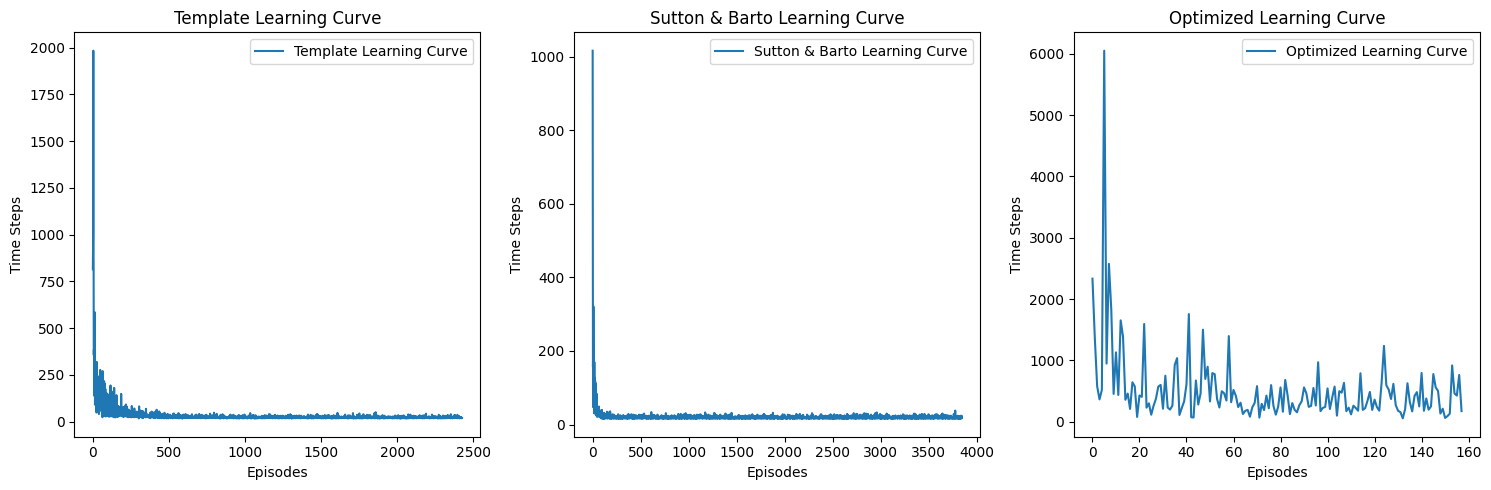

In [81]:
def plot_learning():

    plt.figure(figsize=(15, 5))  # Adjust the figure size for better visibility

    # Plot for Template Learning Curve
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    plt.plot(template_num_steps_per_episodes, label='Template Learning Curve')
    plt.xlabel("Episodes")
    plt.ylabel("Time Steps")
    plt.title("Template Learning Curve")
    plt.legend()

    # Plot for Sutton & Barto Learning Curve
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    plt.plot(ref_num_steps_per_episodes, label='Sutton & Barto Learning Curve')
    plt.xlabel("Episodes")
    plt.ylabel("Time Steps")
    plt.title("Sutton & Barto Learning Curve")
    plt.legend()

    # Plot for Optimized Learning Curve
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    plt.plot(best_num_steps_per_episodes, label='Optimized Learning Curve')
    plt.xlabel("Episodes")
    plt.ylabel("Time Steps")
    plt.title("Optimized Learning Curve")
    plt.legend()

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()

plot_learning()

### Background

First define some key terms.

#### Episode
This is a sequence of actions the agent takes, starting from initial state (S_start) and ending when the agent reaches the terminal state (S_goal). It represents one complete journey of the agent from start to goal, in this case, an episode completes when the agent reaches the location (3, 7).

#### Time Step
This represents one iteration within an episode where the agent makes a decision to take an action. At each time step, the agent considers its current state, selects and performs an action, and receives a reward. It also observes the new state (resulting from the action taken) and updates its policy based on the received reward and the new state. The time steps continue accumulating within an episode until the goal is reached.

### Learning plot
In Gridworld algorithm, the agent learns the optimal path to reach the goal state by interacting with the environment over multiple episodes. Learning is visualized in our plot of time steps versus episodes. The y-axis shows time steps the agent took to reach the goal state in each episode. Fewer time steps per episode indicate a more efficient path taken. The x-axis shows the progression of episodes.

### Observations and Analysis
At the start of the learning process, the agent is taking more time steps to reach the goal because it is still exploring the environment and learning the effects of actions. With more episodes, it the learning from past outcomes (reinforcement) is progressively finding more efficient paths and thus reducing number of time steps needed to reach the goal.

The trend in the plot shows a decreasing number of time steps per episode, indicating the agent is learning and improving its policy to reach the goal more efficiently with time. This is the result of the agent gradually shifting from exploring the environment (choosing actions randomly) to exploiting its learned knowledge (choosing best-known actions) to navigate the gridworld effectively despite the wind's influence.

### Policy Grid

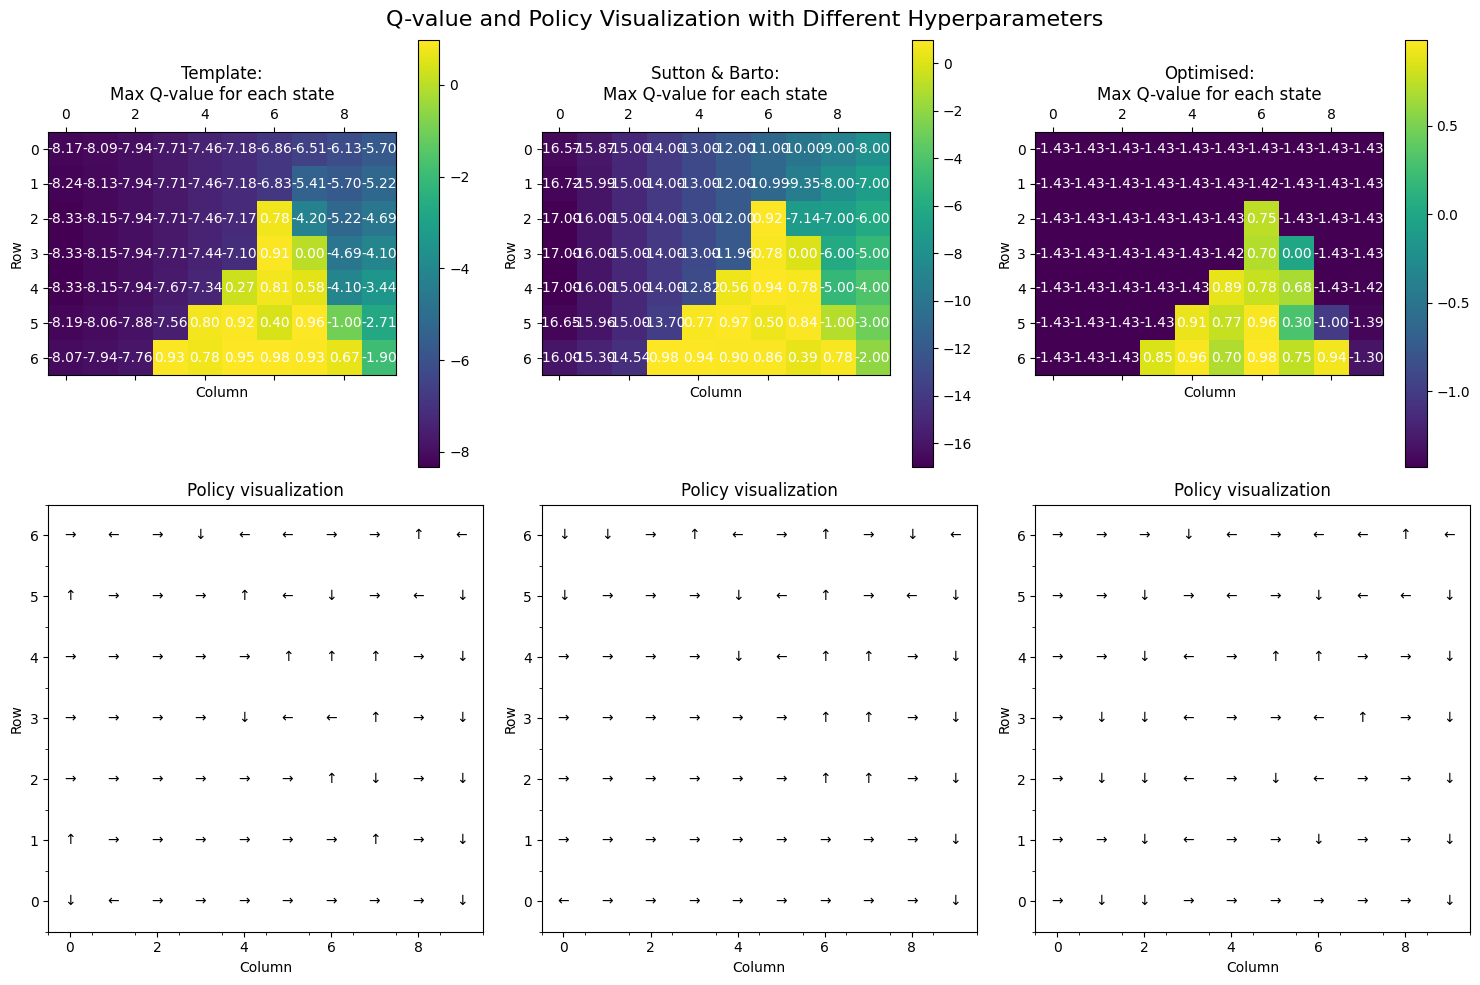

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming baseline_Q, intermediate_Q, and optimized_Q are defined Q-tables
# and num_rows, num_cols are defined

def plot_Q_table(Q, num_rows, num_cols, ax, title = ""):
    Q_grid = Q.max(axis=2)  # Get the max Q-value for each state
    cax = ax.matshow(Q_grid, cmap='viridis')
    fig.colorbar(cax, ax=ax)

    # Annotate each cell with the max Q-value
    for i in range(num_rows):
        for j in range(num_cols):
            ax.text(j, i, f'{Q_grid[i, j]:.2f}', va='center', ha='center', color='w')

    ax.set_title(f"{title}Max Q-value for each state")
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

def plot_policy(Q, num_rows, num_cols, ax):
    policy = np.argmax(Q, axis=2)
    action_arrows = {0: '↑', 1: '↓', 2: '→', 3: '←'}

    for i in range(num_rows):
        for j in range(num_cols):
            action = policy[i, j]
            ax.text(j, i, f'{action_arrows[action]}', ha='center', va='center')

    ax.set_xlim(-0.5, num_cols - 0.5)
    ax.set_ylim(-0.5, num_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, num_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, num_rows, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.set_title('Policy visualization')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Q-value and Policy Visualization with Different Hyperparameters', fontsize=16)

# Plotting for the baseline Q-table
plot_Q_table(template_Q, num_rows, num_cols, axs[0, 0], "Template:\n")
plot_policy(template_Q, num_rows, num_cols, axs[1, 0])

# Assuming intermediate_Q and optimized_Q are also defined
# Plotting for the intermediate Q-table
plot_Q_table(ref_Q, num_rows, num_cols, axs[0, 1], "Sutton & Barto:\n")
plot_policy(ref_Q, num_rows, num_cols, axs[1, 1])

# Plotting for the optimized Q-table
plot_Q_table(best_Q, num_rows, num_cols, axs[0, 2], "Optimised:\n")
plot_policy(best_Q, num_rows, num_cols, axs[1, 2])

plt.tight_layout()
plt.show()


## Sarsa

In [88]:
update_method = 2   # SARSA

template_Q, template_num_episodes_at_step, template_num_steps_per_episodes = TD_windy_gridworld(update_method=update_method)    # SARSA

ref_Q, ref_num_episodes_at_step, ref_num_steps_per_episodes = TD_windy_gridworld(alpha=0.5,   # Sutton & Barto example
                                                                                 gamma=1.0,   # no discounting
                                                                                 epsilon=0.1,
                                                                                 update_method=update_method)  # SARSA

best_Q, best_num_episodes_at_step, best_num_steps_per_episodes = TD_windy_gridworld(alpha=best_alpha,
                                                                                    gamma=best_gamma,
                                                                                    epsilon=best_epsilon,
                                                                                    update_method=update_method)  # SARSA


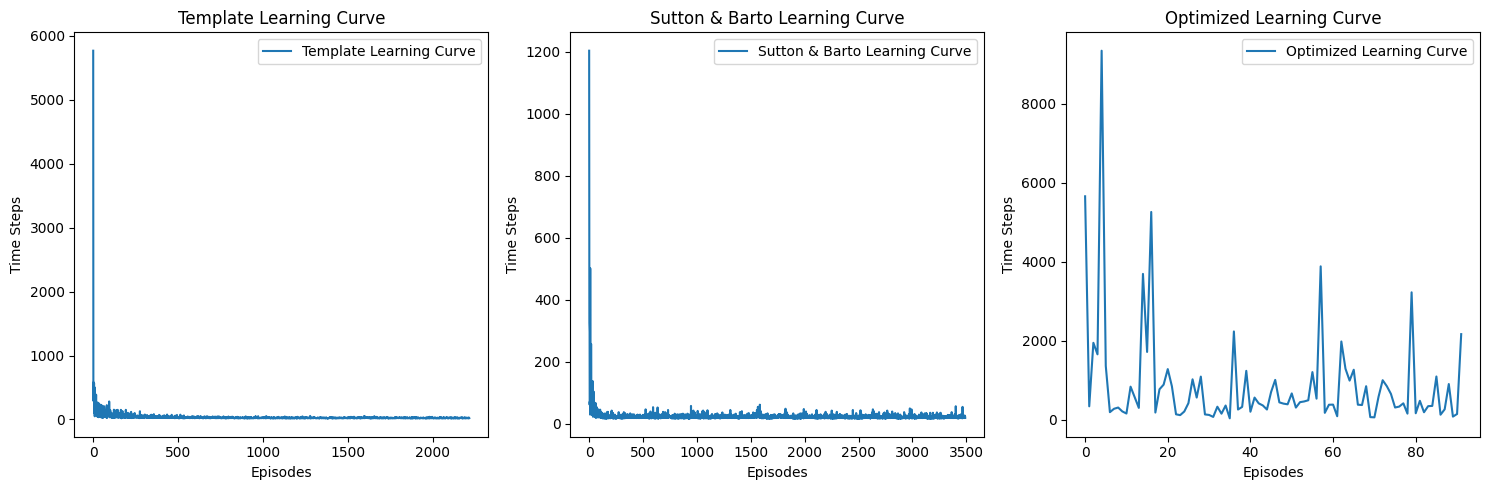

In [90]:
plot_learning()

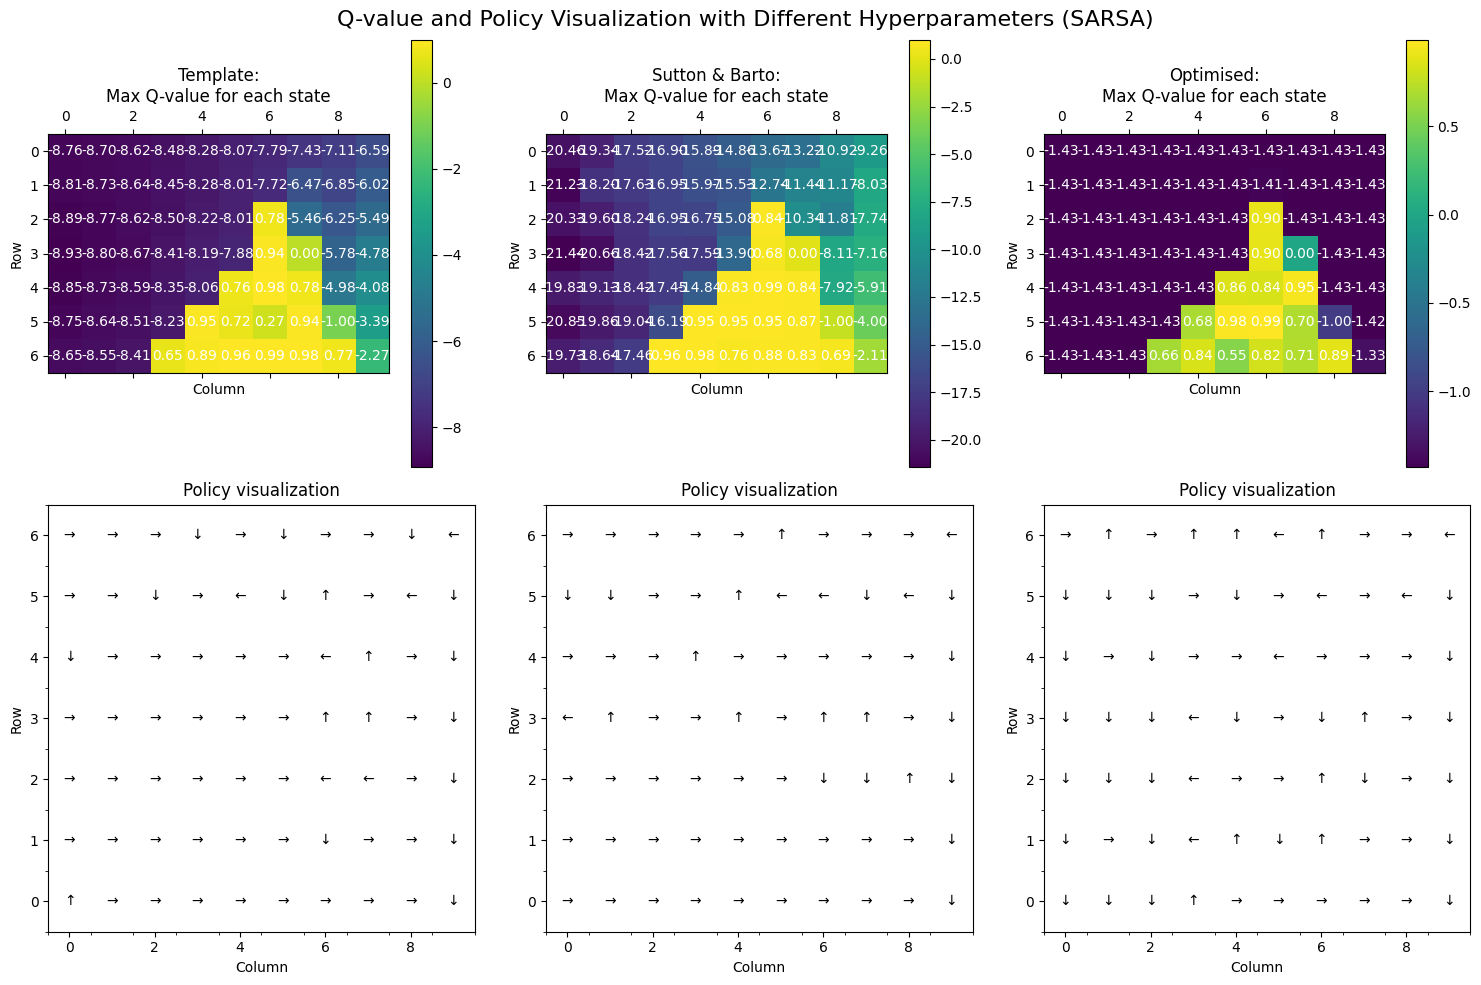

In [91]:
# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Q-value and Policy Visualization with Different Hyperparameters (SARSA)', fontsize=16)

# Plotting for the baseline Q-table
plot_Q_table(template_Q, num_rows, num_cols, axs[0, 0], "Template:\n")
plot_policy(template_Q, num_rows, num_cols, axs[1, 0])

# Assuming intermediate_Q and optimized_Q are also defined
# Plotting for the intermediate Q-table
plot_Q_table(ref_Q, num_rows, num_cols, axs[0, 1], "Sutton & Barto:\n")
plot_policy(ref_Q, num_rows, num_cols, axs[1, 1])

# Plotting for the optimized Q-table
plot_Q_table(best_Q, num_rows, num_cols, axs[0, 2], "Optimised:\n")
plot_policy(best_Q, num_rows, num_cols, axs[1, 2])

plt.tight_layout()
plt.show()
